## Analyze and identify the key factors influencing delivery time, and recommend targeted solutions to reduce delays and improve overall logistics efficiency. 

#### The purpose of the analysis: Explore which factors causes delivery delays and offer appropriate solutions.<br>The dataset used: Brazilian E-Commerce Dataset by Olist.<br>An overview of methods: Correlation analysis, Performance metrics, Targeted solutions.


## Load data

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
# Load the data 
df_orders = pd.read_gbq('SELECT * FROM project-brazilian-ecommerce.ecommerce_data.fact_orders', project_id='project-brazilian-ecommerce')
df_order_items = pd.read_gbq('SELECT * FROM project-brazilian-ecommerce.ecommerce_data.dim_order_items', project_id='project-brazilian-ecommerce')
df_payments = pd.read_gbq('SELECT * FROM project-brazilian-ecommerce.ecommerce_data.dim_payments', project_id='project-brazilian-ecommerce')
df_customers = pd.read_gbq('SELECT * FROM project-brazilian-ecommerce.ecommerce_data.dim_customers', project_id='project-brazilian-ecommerce')

C:\Users\anjal\anaconda3\lib\site-packages\google\cloud\bigquery\table.py:2518: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
C:\Users\anjal\anaconda3\lib\site-packages\google\cloud\bigquery\table.py:2532: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
C:\Users\anjal\anaconda3\lib\site-packages\google\cloud\bigquery\table.py:2546: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


## Data Cleaning and Preprocessing 

In [39]:
# Convert the datetime columns to datetime dtype
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'], errors='coerce')
df_orders['order_delivered_customer_date'] = pd.to_datetime(df_orders['order_delivered_customer_date'], errors='coerce')

# Calculate the delivery time in days
df_orders['delivery_time_days'] = (df_orders['order_delivered_customer_date'] - df_orders['order_purchase_timestamp']).dt.days

# Handle NaN values in 'delivery_time_days' by filling them with a default value 
df_orders['delivery_time_days'] = df_orders['delivery_time_days'].fillna(0).astype(int)

In [40]:
# Merging the data
df = pd.merge(df_orders, df_order_items[['order_id', 'price', 'freight_value', 'product_category_name_english']], on='order_id', how='left')
df = pd.merge(df, df_payments[['order_id', 'payment_type']], on='order_id', how='left')
df = pd.merge(df, df_customers[['customer_id', 'customer_city', 'customer_state']], on='customer_id', how='left')

In [41]:
# New column added to store month of the order
df['order_month'] = df['order_purchase_timestamp'].dt.month

## Correlation Analysis

#### Freight Value, Total Order Value, Price, Payment type

In [73]:
# Convert the 'payment_type' column into dummy variables for each category
# This transforms the  column (which contains categorical values into numerical dummy variables that represent each category.
df = pd.get_dummies(df, columns=['payment_type'], drop_first=True)
# Compute correlation matrix for numerical columns
correlation_matrix = df.corr()

# Display correlation with 'delivery_time_days'
correlation_with_delivery_time = correlation_matrix['delivery_time_days'].sort_values(ascending=False)
print(correlation_with_delivery_time)

delivery_time_days          1.000000
freight_value               0.201417
total_order_value           0.056452
price                       0.054286
payment_type_voucher        0.002429
payment_type_debit_card    -0.021793
payment_type_credit_card   -0.038953
order_month                -0.052159
on_time                    -0.478949
Name: delivery_time_days, dtype: float64


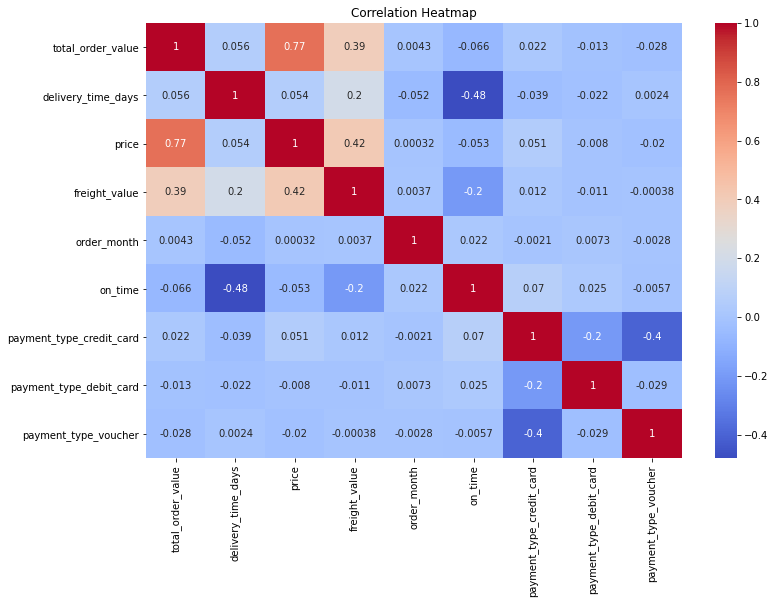

In [80]:
# Correlation heatmap
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Freight Value: The correlation is 0.201417, suggesting a positive relationship between freight costs and delivery time. Orders with higher freight values might take slightly longer to deliver.

#### Customer states

In [81]:
# Converts the categorical column into multiple binary columns, where each column represents a unique state in the dataset.
df_state = pd.get_dummies(df, columns=['customer_state'], drop_first=True)
# Compute correlation matrix for numerical columns
correlation_matrix = df_state.corr()

# Display correlation with 'delivery_time_days'
correlation_with_delivery_time = correlation_matrix['delivery_time_days'].sort_values(ascending=False)
#print(correlation_with_delivery_time)

# Filter only the columns for customer states (those starting with 'customer_state_')
state_columns = [col for col in correlation_with_delivery_time.index if col.startswith('customer_state_')]

# Extract correlations for customer states only
state_correlations = correlation_with_delivery_time[state_columns]

# Sort the correlations in descending order
sorted_state_correlations = state_correlations.sort_values(ascending=False)

# Display the sorted correlations for states
#print(sorted_state_correlations)

# Get top 10 states with the highest correlation
top_10_states_highest = state_correlations.sort_values(ascending=False).head(10)

# Get top 10 states with the lowest correlation
top_10_states_lowest = state_correlations.sort_values(ascending=True).head(10)

# Display results
print("Top 10 States with Highest Correlation:")
print(top_10_states_highest)


Top 10 States with Highest Correlation:
customer_state_BA    0.127292
customer_state_PA    0.112645
customer_state_RJ    0.104589
customer_state_CE    0.096113
customer_state_MA    0.078974
customer_state_AL    0.075429
customer_state_PE    0.073309
customer_state_RS    0.068532
customer_state_PB    0.061065
customer_state_AM    0.056265
Name: delivery_time_days, dtype: float64


Bahia (BA) (0.127292): Orders to Bahia have the highest positive correlation with delivery time, indicating that deliveries to this state tend to take longer. Pará (PA) (0.112645) and Rio de Janeiro (RJ) (0.104589) also show relatively strong positive correlations, suggesting extended delivery times compared to other states.

In [43]:
print("\nTop 10 States with Lowest Correlation:")
print(top_10_states_lowest)



Top 10 States with Lowest Correlation:
customer_state_SP   -0.328215
customer_state_MG   -0.016921
customer_state_PR   -0.010241
customer_state_DF    0.006923
customer_state_TO    0.026327
customer_state_MS    0.028128
customer_state_RR    0.028405
customer_state_RO    0.037036
customer_state_GO    0.042954
customer_state_AP    0.043739
Name: delivery_time_days, dtype: float64


São Paulo stands out with a notable negative correlation, indicating significantly shorter delivery times compared to other states. This may reflect better infrastructure or proximity to distribution centers.

#### Product categories

In [35]:
# Filter product category columns only
product_category_columns = [col for col in correlation_with_delivery_time.index if col.startswith('product_category_name_english')]

# Extract correlations for product categories
product_category_correlations = correlation_with_delivery_time[product_category_columns]

# Sort correlations in descending order
sorted_product_category_correlations = product_category_correlations.sort_values(ascending=False)

# Display the correlations
#print(sorted_product_category_correlations)

# Display the top 10 product categories with the highest correlations
top_10_categories = product_category_correlations.sort_values(ascending=False).head(10)
print(top_10_categories)



product_category_name_english_office_furniture         0.109970
product_category_name_english_garden_tools             0.025244
product_category_name_english_computers_accessories    0.021086
product_category_name_english_fashion_shoes            0.013979
product_category_name_english_bed_bath_table           0.013758
product_category_name_english_christmas_supplies       0.012325
product_category_name_english_furniture_living_room    0.010839
product_category_name_english_furniture_decor          0.010794
product_category_name_english_consoles_games           0.008461
product_category_name_english_electronics              0.008421
Name: delivery_time_days, dtype: float64


Office furniture has the strongest positive correlation with delivery time, suggesting that orders for this category might tend to experience longer delivery times. Garden tools show a slight positive correlation, indicating slightly longer delivery times for orders in this category.

In [33]:
# Display the bottom 10 product categories with the lowest correlations
bottom_10_categories = product_category_correlations.sort_values(ascending=True).head(10)
print(bottom_10_categories)


product_category_name_english_housewares                        -0.040705
product_category_name_english_food                              -0.019931
product_category_name_english_fashion_bags_accessories          -0.017383
product_category_name_english_luggage_accessories               -0.016943
product_category_name_english_construction_tools_construction   -0.016173
product_category_name_english_toys                              -0.015579
product_category_name_english_pet_shop                          -0.015326
product_category_name_english_health_beauty                     -0.014889
product_category_name_english_construction_tools_lights         -0.014455
product_category_name_english_drinks                            -0.013759
Name: delivery_time_days, dtype: float64


Housewares have the strongest negative correlation, suggesting that orders for this category may experience slightly faster delivery times compared to others. Food-related orders are also somewhat negatively correlated, implying shorter delivery times.

#### Month of the year

In [103]:
# Group by 'order_month' and calculate the mean delivery time for each month
monthly_delivery_mean = df.groupby('order_month')['delivery_time_days'].mean()

# Display the mean delivery time for each month
print(monthly_delivery_mean)


order_month
1     13.169843
2     15.275641
3     14.330064
4     11.453401
5     10.674566
6      9.537105
7      9.254375
8      8.379829
9     11.340580
10    11.422450
11    14.194987
12    14.541660
Name: delivery_time_days, dtype: float64


February (Month 2) has the longest average delivery time at 15.28 days. Other months with long average delivery times include March (14.33 days), November (14.19 days), and December (14.54 days), likely reflecting possible delays due to seasonal or logistical factors (e.g., holidays).

August (Month 8) shows the shortest average delivery time at 8.38 days. July and June also have relatively short delivery times at 9.25 days and 9.54 days, respectively.


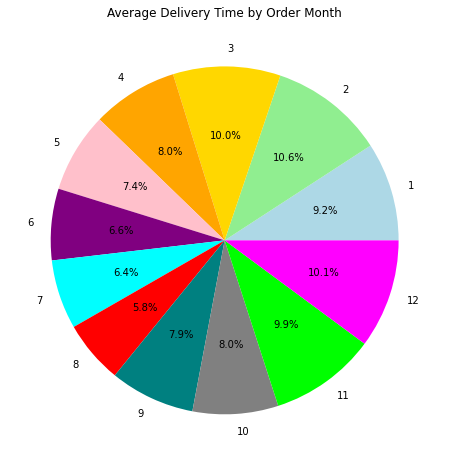

In [104]:
import matplotlib.pyplot as plt

# Example: Pie chart for average delivery times by month
monthly_delivery_mean.plot(
    kind='pie',
    autopct='%1.1f%%',  # Show percentage values
    figsize=(8, 8),      # Adjust the size
    colors=['lightblue', 'lightgreen', 'gold', 'orange', 'pink', 'purple', 'cyan', 'red', 'teal', 'gray', 'lime', 'magenta']
)
plt.title('Average Delivery Time by Order Month')
plt.ylabel('')  # Hide y-axis label for better appearance
plt.show()


#### Overall Delivery Performance

In [101]:
# Calculate overall performance metrics
overall_delivery_performance = {
    'Average_Delivery_Time': df_orders['delivery_time_days'].mean(),
    'Median_Delivery_Time': df_orders['delivery_time_days'].median(),
    'On_Time_Percentage': (df_orders['on_time'].mean() * 100) if 'on_time' in df_orders else 'N/A',
    'Total_Orders': len(df_orders),
    'Standard_Deviation_Delivery_Time': df_orders['delivery_time_days'].std()
}

for metric, value in overall_delivery_performance.items():
    print(f"{metric}: {value:.2f}" if isinstance(value, (int, float)) else f"{metric}: {value}")


Average_Delivery_Time: 11.83
Median_Delivery_Time: 10.00
On_Time_Percentage: 0.00
Total_Orders: 98666.00
Standard_Deviation_Delivery_Time: 9.61


It takes approximately 11.83 days for orders to be delivered. Half of the orders were delivered within 10 days or fewer. No orders were marked as delivered on or before the promised delivery time. 98,666 orders processed in total in two years.

#### State-wise breakdown

In [56]:
# Group by customer_state (or customer_city) and calculate metrics
regional_delivery_performance = df.groupby('customer_state').agg({
    'delivery_time_days': ['mean', 'median'],  # Average and median delivery time
    'order_id': 'count'  # Total number of orders
}).reset_index()

# Rename columns for readability
regional_delivery_performance.columns = ['State', 'Average_Delivery_Time', 'Median_Delivery_Time', 'Total_Orders']

#print(regional_delivery_performance)

# Sort regional_delivery_performance by Average_Delivery_Time in ascending order
regional_delivery_performance_sorted = regional_delivery_performance.sort_values(by='Average_Delivery_Time', ascending=True)

# Display the sorted DataFrame
print(regional_delivery_performance_sorted)

   State  Average_Delivery_Time  Median_Delivery_Time  Total_Orders
25    SP               8.095887                     7         49569
10    MG              11.312069                    10         13638
17    PR              11.334955                    10          5962
6     DF              12.206632                    11          2473
23    SC              14.232218                    12          4302
18    RJ              14.329223                    11         15327
22    RS              14.457601                    13          6486
8     GO              14.572428                    13          2430
11    MS              14.908660                    13           843
7     ES              15.024380                    13          2338
26    TO              16.418879                    15           339
12    MT              16.809778                    16          1125
15    PE              17.219693                    15          1889
4     BA              18.175889                 

Text(0, 0.5, 'Average Delivery Time (days)')

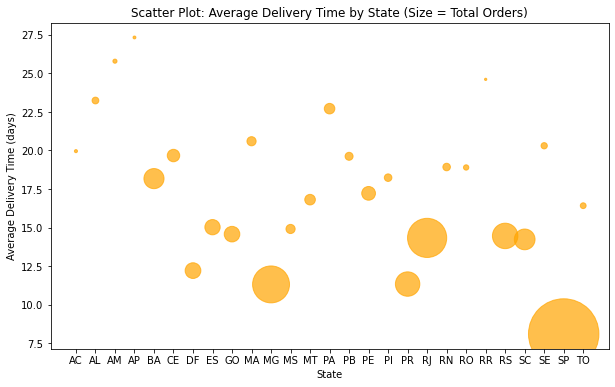

In [98]:
# Scatter plot for average delivery time by state
plt.figure(figsize=(10, 6))  # Adjust plot size
plt.scatter(
    regional_delivery_performance['State'], 
    regional_delivery_performance['Average_Delivery_Time'], 
    s=regional_delivery_performance['Total_Orders'] * 0.1,  # Scale size of points
    color='orange', 
    alpha=0.7
)
plt.title('Scatter Plot: Average Delivery Time by State (Size = Total Orders)')
plt.xlabel('State')
plt.ylabel('Average Delivery Time (days)')



The state Amapá (AP), a state located in the North Region of Brazil have fewer orders, but those few orders take unusually long (leading to a high average).<br>
While Bahia (BA) shows a strong correlation with delivery time, it does not have the longest average delivery time. This may be because correlation measures how changes in one variable (delivery time) align with another variable (e.g. state BA ) rather than absolute values. Meanwhile, Amapá's low order volume could skew averages due to outliers with extremely long delivery times.

#### On-time delivery percentage for each state

In [66]:
#df_orders = pd.read_gbq('SELECT * FROM project-brazilian-ecommerce.ecommerce_data.fact_orders', project_id='project-brazilian-ecommerce')
# Create a column to flag on-time deliveries
df['on_time'] = df['order_delivered_customer_date'] <= (df['order_purchase_timestamp'] + pd.Timedelta(days=7))

# Calculate on-time delivery percentage by state
on_time_delivery = df.groupby('customer_state')['on_time'].mean() * 100
on_time_delivery_sorted = on_time_delivery.sort_values(ascending=True)
# Display the results
print(on_time_delivery_sorted)


customer_state
AC     0.000000
RO     0.000000
PA     0.806452
AL     0.873362
AP     1.190476
SE     1.259446
MT     1.511111
PI     1.919721
RR     1.923077
MA     2.014218
PB     2.503912
TO     2.654867
CE     2.836879
BA     3.063241
PE     3.123346
AM     4.093567
GO     4.650206
RN     5.096661
MS     5.100830
ES     5.688623
RS     9.158187
SC    11.971176
DF    15.406389
RJ    16.324134
PR    19.305602
MG    19.900279
SP    45.786681
Name: on_time, dtype: float64


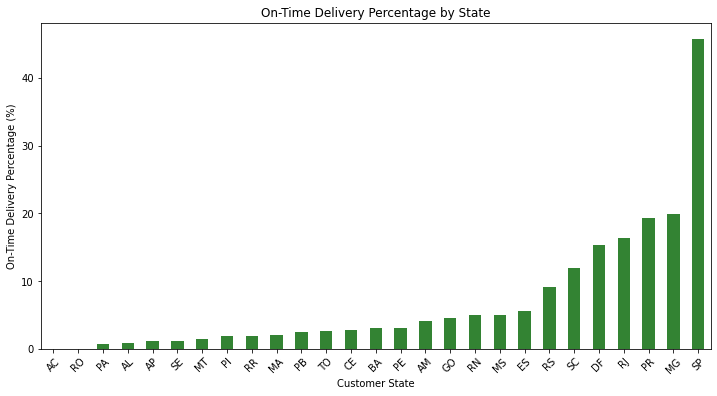

In [99]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
on_time_delivery_sorted.plot(kind='bar', color='darkgreen', alpha=0.8)
plt.title('On-Time Delivery Percentage by State')
plt.xlabel('Customer State')
plt.ylabel('On-Time Delivery Percentage (%)')
plt.xticks(rotation=45)
plt.show()


States like São Paulo (SP) with 45.78% have significantly better on-time delivery performance. This is likely due to superior logistics infrastructure and proximity to distribution centers. States like Acre (AC) and Rondônia (RO) have 0% on-time deliveries, indicating severe delays possibly caused by remote locations, poor infrastructure, or logistical challenges.

## Key Insights
#### There’s a positive relationship between freight value and delivery time. Orders with higher freight costs tend to take slightly longer to deliver, reflecting the complexity or handling requirements of higher-value shipments.

#### States like Bahia, Pará, and Rio de Janeiro, shows the strongest correlation to delivery time. While the state like Amapá, the state of Amazonas, which are located in the north part of the country, likely face logistical challenges such as accessibility, infrastructure, or proximity to warehouses. São Paulo stands out with significantly shorter delivery times due to better infrastructure and proximity to major distribution centers.

#### Office furniture shows the strongest positive correlation, suggesting that orders in this category might take longer due to size or shipping requirements. Housewares have the strongest negative correlation, indicating faster deliveries, possibly due to easier stock availability or simpler shipping logistics. Food-related orders also show a minor negative correlation, suggesting quicker deliveries. 

#### February has the longest average delivery time, followed by March, November, and December. Seasonal peaks, holidays, and higher demand likely contribute to these delays.

## Proposed Solution

#### Expand Warehouse Network: Build smaller, regional warehouses in or near these areas to reduce transit times. Dedicated Logistics for Bulky Items: Use specialized transportation for larger categories like office furniture to minimize delays.Use predictive analytics to stock up on popular items ahead of seasonal peaks.
